Мета: аналіз статей та пошук найбільш оптимальної моделі машинного навчання для прогнозування електроспоживання, яка зможе покращити вже існуючі показники.

У цій роботі проводилось дослідження 15-ти хвилинного та погодинного наборів даних "Steel industry energy consumption" зібраних з корейської сталеварної фабрики DAEWOO. Після попереднього аналізу виконувалась певне очищення даних та підготовка наборів до розбиття на вибірки train та test. Аналіз показав, що всі ознаки у датасетах впливають на результат прогнозування. Також було виявлено, що 15-ти хвилинний набір повністю конвертується у погодинний, тобто сумарне значення 4ьох записів 15-ти хвилинного набору дорівнювало 1 значенню погодинного. Під час аналізу виникали певні зауваження, як наприклад те, що у вихідні дні спостерігалось значно менше використання електроенергії.

Спочатку було використано просту модель лінійної регресії щоб порівняти результати метрик зі статтями, а саме MAPE, MAE, RMSE. Як висновок, результати були майже ідентичні. Також було перевірено можливість прогнозування погодинного споживання використовуючи 15-ти хвилинний набір. Було навчено і спрогнозовано 15-ти хвилинний набір після чого дані конвертувались в погодинні. Результат показав, що прогнози погодинного набору з використанням такої методики ставали точніші.

Далі було використано моделі багатошарового персептрона (MLP) та Cubist. Гіперпараметри підбирались з використанням крос-валідації, також було застосовано TimeSeriesSplit, що давало змогу зберігати хронологічний порядок у даних і виконувати навчання на минулих і валідувати на майбутніх. Це зроблено тому що метою було прогнозування саме майбутнього використання енергії, а також це могло покращити точність моделей.

Після підбору гіперпараметрів виконано навчання моделей та прогнозування тестових вибірок і визначення метрик якості. Шляхом порівняння метрик зі статтями було виявлено, що обидві запропоновані моделі покращують результати і точність прогнозування. Найкраще себе показав саме метод Cubist.

###Бібліотеки


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error
from joblib import dump, load

In [ ]:
#!pip install -U numpy
#!pip install cubist
# перезапуск середовища виконання

In [ ]:
from cubist import Cubist

# Дослідження погодинного набору

##Початковий аналіз

In [ ]:
df = pd.read_csv('hourlydata.csv', parse_dates=[0], dayfirst=True, index_col='date')
df

In [ ]:
df.shape

(8760, 10)

In [ ]:
df.head()

,Usage,Hour,LagRP,LeadRP,LagPF,LeadPF,CO2,Ltype,Wstatus,Dweek
date,,,,,,,,,,
2018-01-01,13.72,1,14.25,0,0.0,100.0,0.0,Light_Load,Weekday,Monday
2018-01-01,14.30,2,16.48,0,0.0,100.0,0.0,Light_Load,Weekday,Monday
2018-01-01,13.76,3,16.03,0,0.0,100.0,0.0,Light_Load,Weekday,Monday
2018-01-01,14.47,4,17.56,0,0.0,100.0,0.0,Light_Load,Weekday,Monday
2018-01-01,13.89,5,16.24,0,0.0,100.0,0.0,Light_Load,Weekday,Monday


In [ ]:
df.columns

Index(['Usage', 'Hour', 'LagRP', 'LeadRP', 'LagPF', 'LeadPF', 'CO2', 'Ltype',
       'Wstatus', 'Dweek'],
      dtype='object')

In [ ]:
df.describe()

,Usage,Hour,LagPF,LeadPF,CO2
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,109.547629,12.500000,54.274884,41.162003,0.011524
std,129.333865,6.922582,46.438031,48.916946,0.015579
min,9.830000,1.000000,0.000000,0.000000,0.000000
25%,12.950000,6.750000,0.000000,0.000000,0.000000
50%,18.350000,12.500000,86.915000,0.000000,0.000000
75%,210.632500,18.250000,97.465000,100.000000,0.025000
max,564.300000,24.000000,100.000000,100.000000,0.067500


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 to 2018-12-31
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Usage    8760 non-null   float64
 1   Hour     8760 non-null   int64  
 2   LagRP    8760 non-null   object 
 3   LeadRP   8760 non-null   object 
 4   LagPF    8760 non-null   float64
 5   LeadPF   8760 non-null   float64
 6   CO2      8760 non-null   float64
 7   Ltype    8760 non-null   object 
 8   Wstatus  8760 non-null   object 
 9   Dweek    8760 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 752.8+ KB


## Зміна та редактування

In [ ]:
def rofl(x):
  x = ''.join(x.split(' '))
  if x == 'NA':
    x = 0
  elif x == '91':
    x = 9.1
  return x

In [ ]:
df_hourscolumn = pd.read_csv('hourlydata.csv', parse_dates=[0], dayfirst=True, index_col='date')
df_hourscolumn['LeadRP'] = df_hourscolumn['LeadRP'].apply(rofl)
df_hourscolumn['LagRP'] = df_hourscolumn['LagRP'].apply(rofl)
df_hourscolumn['LeadRP'] = df_hourscolumn['LeadRP'].astype('float64')
df_hourscolumn['LagRP'] = df_hourscolumn['LagRP'].astype('float64')
df_hourscolumn

,Usage,Hour,LagRP,LeadRP,LagPF,LeadPF,CO2,Ltype,Wstatus,Dweek
date,,,,,,,,,,
2018-01-01,13.72,1,14.25,0.00,0.00,100.00,0.0,Light_Load,Weekday,Monday
2018-01-01,14.30,2,16.48,0.00,0.00,100.00,0.0,Light_Load,Weekday,Monday
2018-01-01,13.76,3,16.03,0.00,0.00,100.00,0.0,Light_Load,Weekday,Monday
2018-01-01,14.47,4,17.56,0.00,0.00,100.00,0.0,Light_Load,Weekday,Monday
2018-01-01,13.89,5,16.24,0.00,0.00,100.00,0.0,Light_Load,Weekday,Monday
...,...,...,...,...,...,...,...,...,...,...
2018-12-31,16.45,20,0.00,78.55,100.00,0.00,0.0,Light_Load,Weekday,Monday
2018-12-31,14.40,21,0.00,60.20,100.00,0.00,0.0,Light_Load,Weekday,Monday
2018-12-31,13.75,22,0.00,53.18,100.00,0.00,0.0,Light_Load,Weekday,Monday


In [ ]:
df_hourscolumn.describe()

,Usage,Hour,LagRP,LeadRP,LagPF,LeadPF,CO2
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,109.547629,12.500000,52.141492,15.483781,54.274884,41.162003,0.011524
std,129.333865,6.922582,61.697062,28.703758,46.438031,48.916946,0.015579
min,9.830000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.950000,6.750000,11.490000,0.000000,0.000000,0.000000,0.000000
50%,18.350000,12.500000,20.440000,0.000000,86.915000,0.000000,0.000000
75%,210.632500,18.250000,94.040000,12.860000,97.465000,100.000000,0.025000
max,564.300000,24.000000,311.330000,110.350000,100.000000,100.000000,0.067500


In [ ]:
df_hourscolumn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 to 2018-12-31
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Usage    8760 non-null   float64
 1   Hour     8760 non-null   int64  
 2   LagRP    8760 non-null   float64
 3   LeadRP   8760 non-null   float64
 4   LagPF    8760 non-null   float64
 5   LeadPF   8760 non-null   float64
 6   CO2      8760 non-null   float64
 7   Ltype    8760 non-null   object 
 8   Wstatus  8760 non-null   object 
 9   Dweek    8760 non-null   object 
dtypes: float64(6), int64(1), object(3)
memory usage: 752.8+ KB


## Подальше дослідження і побудова графіків

**Таблица и график корреляции каждой переменной**

In [ ]:
#correlation of each variable
df_hourscolumn.corr()

<ipython-input-24-4934fad7e5ba>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_hourscolumn.corr()


,Usage,Hour,LagRP,LeadRP,LagPF,LeadPF,CO2
Usage,1.000000,0.221337,0.904212,-0.328885,0.435496,-0.454094,0.992739
Hour,0.221337,1.000000,0.074177,0.365106,0.662179,-0.683454,0.219115
LagRP,0.904212,0.074177,1.000000,-0.421212,0.196268,-0.237253,0.899232
LeadRP,-0.328885,0.365106,-0.421212,1.000000,0.503443,-0.442780,-0.337066
LagPF,0.435496,0.662179,0.196268,0.503443,1.000000,-0.983585,0.431001
LeadPF,-0.454094,-0.683454,-0.237253,-0.442780,-0.983585,1.000000,-0.449862
CO2,0.992739,0.219115,0.899232,-0.337066,0.431001,-0.449862,1.000000


<ipython-input-25-7e3f297bc73c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_hourscolumn.corr(), annot = True, cmap = 'YlGnBu')


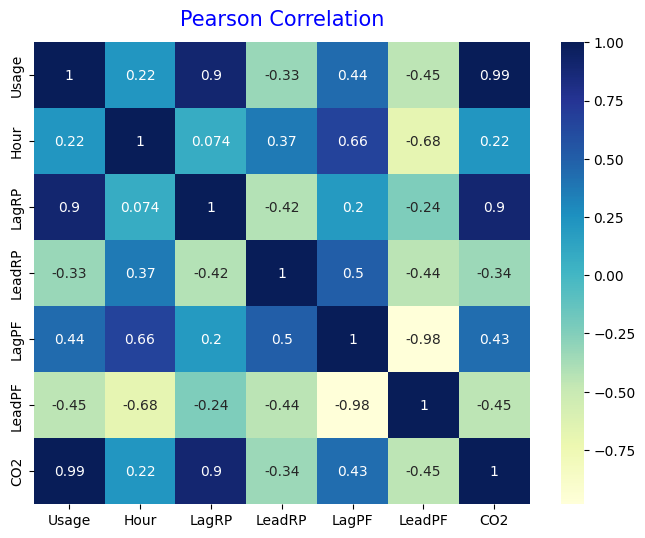

In [ ]:
plt.figure(figsize = (8,6))
sns.heatmap(df_hourscolumn.corr(), annot = True, cmap = 'YlGnBu')
plt.title("Pearson Correlation", fontsize = 15, color = 'b', pad = 12, loc = 'center')
plt.show()

**Таблица максимального использования энергии за час каждый день**

In [ ]:
most_energy_consumption = pd.pivot_table(df_hourscolumn, index = 'date', values = 'Usage', aggfunc = {'Usage' : np.max})
most_energy_consumption.head(10)

,Usage
date,
2018-01-01,15.84
2018-01-02,487.15
2018-01-03,454.10
2018-01-04,508.39
2018-01-05,478.04
2018-01-06,17.22
2018-01-07,15.59
2018-01-08,500.10
2018-01-09,493.77


**График максимального использования энергии за каждый день**

<ipython-input-27-a2f8aa9587c9>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)


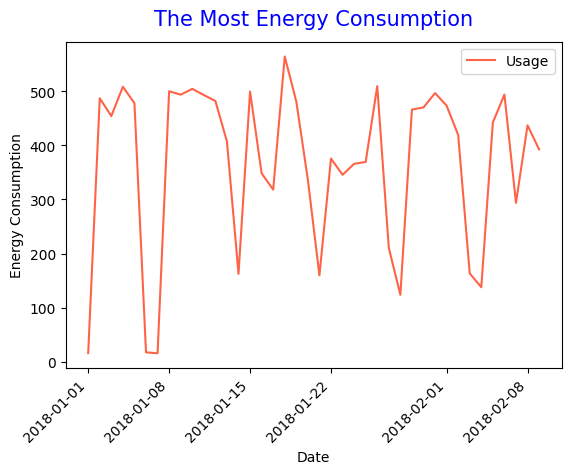

In [ ]:
chart = most_energy_consumption[:40].sort_values(by = 'Usage', ascending = False).plot(kind = 'line', color = 'tomato')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)
plt.title('The Most Energy Consumption', fontsize = 15, color = 'b', loc = 'center', pad = 12)
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.show()

**Таблица среднего использования энергии за каждый день**

In [ ]:
mean_energy_consumption = pd.pivot_table(df_hourscolumn, index = 'date', values = 'Usage', aggfunc = {'Usage' : np.mean})
mean_energy_consumption.head(10)

,Usage
date,
2018-01-01,14.660833
2018-01-02,164.601250
2018-01-03,148.377083
2018-01-04,207.405000
2018-01-05,195.141667
2018-01-06,15.540000
2018-01-07,14.538333
2018-01-08,221.604583
2018-01-09,228.682083


**График среднего использования энергии за каждый день**

<ipython-input-7-e84f931beffa>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)


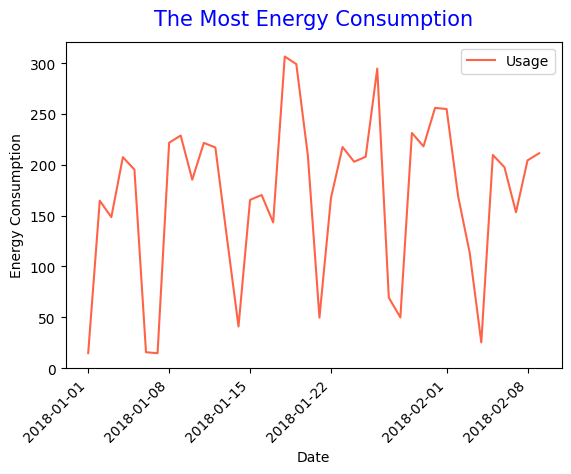

In [ ]:
chart = mean_energy_consumption[:500].sort_values(by = 'Usage', ascending = False).plot(kind = 'line', color = 'tomato')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)
plt.title('The Most Energy Consumption', fontsize = 15, color = 'b', loc = 'center', pad = 12)
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.show()

Text(0, 0.5, 'Використання енергії')

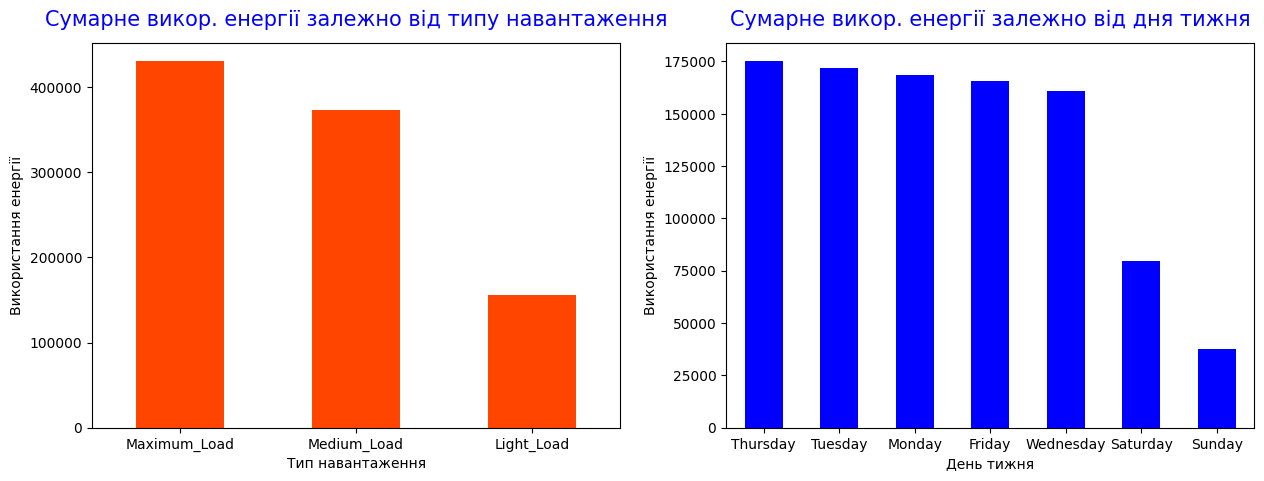

In [ ]:
plt.rcParams['figure.figsize'] = (15,5)
plt.subplot(1, 2, 1)
chart = df_hourscolumn.groupby('Ltype')['Usage'].sum().sort_values(ascending = False).plot(kind = 'bar', color = 'orangered')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 0)
plt.title('Сумарне викор. енергії залежно від типу навантаження', fontsize = 15, color = 'b', pad = 12)
plt.xlabel('Тип навантаження')
plt.ylabel('Використання енергії')

#visualize number of second from midnight based on load type
plt.subplot(1, 2, 2)
chart = df_hourscolumn.groupby('Dweek')['Usage'].sum().sort_values(ascending = False).plot(kind = 'bar', color = 'blue')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 0)
plt.title('Сумарне викор. енергії залежно від дня тижня', fontsize = 15, color = 'b', pad = 12)
plt.xlabel('День тижня')
plt.ylabel('Використання енергії')

Text(0.5, 0, 'День тижня')

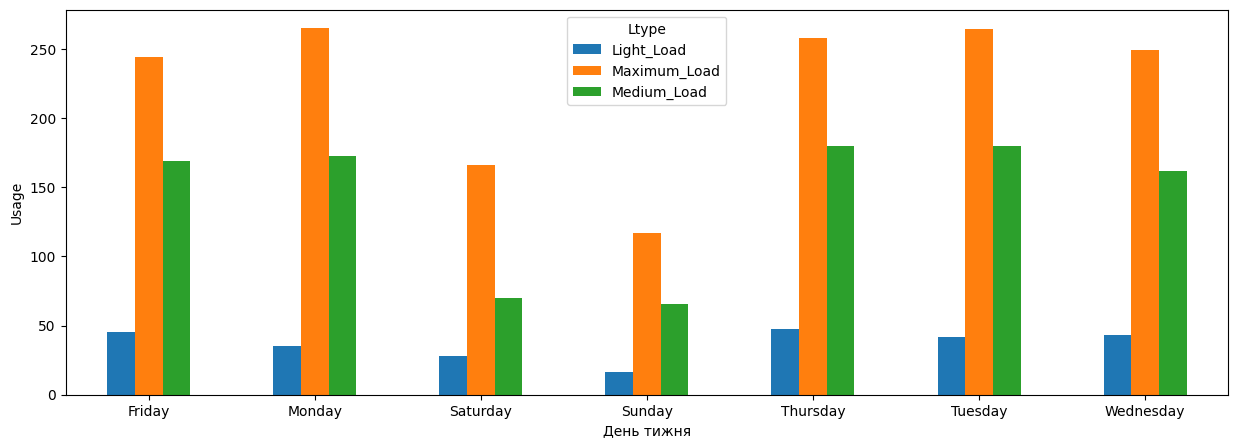

In [ ]:
plt.rcParams['figure.figsize'] = (15,5)
df_hourscolumn.groupby(['Dweek','Ltype'])['Usage'].mean().unstack().plot.bar(rot= 0)
plt.ylabel('Usage')
plt.xlabel('День тижня')
# використання енергії залежно від дня тижня та навантаження

Text(0, 0.5, 'Usage_kWh')

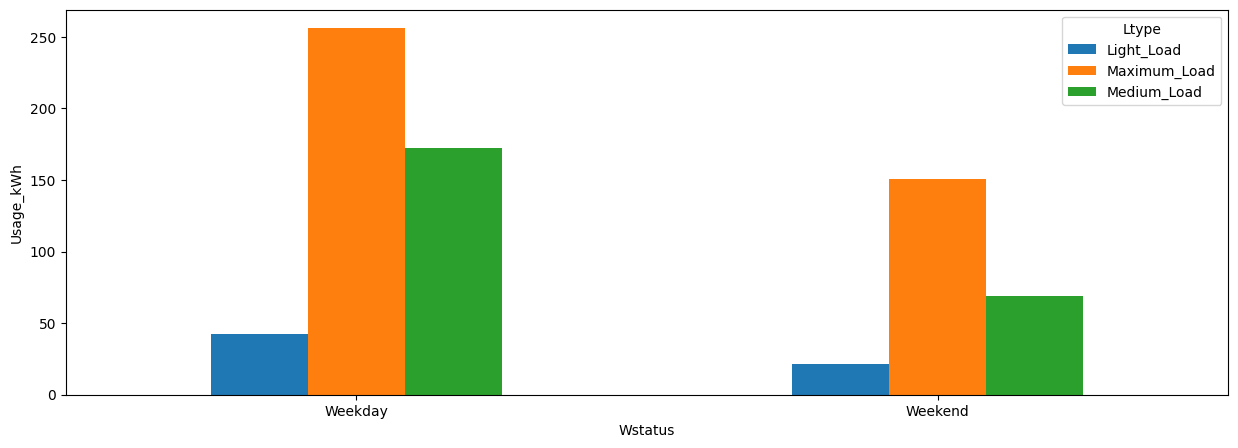

In [ ]:
df_hourscolumn.groupby(['Wstatus','Ltype'])['Usage'].mean().unstack().plot.bar(rot = 0)
plt.ylabel('Usage_kWh')
# використання енергії залежно від статусу дня тижня та навантаження

#start the data for ML models

**to start the data per 15 min :**

In [ ]:
def rename_ind(x):
    if pd.Timestamp(x).hour == 0 and pd.Timestamp(x).minute == 0:
        x = x + pd.Timedelta(24, 'hour')
    return x

In [ ]:
df = pd.read_csv('Steel_industry_data.csv', parse_dates=[0], dayfirst=True, index_col='date')
df = df.rename(index=lambda Index: rename_ind(Index))
df = pd.get_dummies(df, drop_first=False)
df[:4]

**to start the data per hour(separately and not):**

In [ ]:
df_hourly = pd.read_csv('hourlydata.csv', parse_dates=[0], dayfirst=True)
kff = list(df_hourly['date'])
kff1 = list(df_hourly['Hour'])
for x in range(len(kff)):
  kff[x] = kff[x] + pd.Timedelta(kff1[x], 'hour')

def rofl(x):
  x = ''.join(x.split(' '))
  if x == 'NA':
    x = 0
  elif x == '91':
    x = 9.1
  return x

In [ ]:
df_hourly = pd.read_csv('hourlydata.csv', parse_dates=[0], dayfirst=True)
df_hourly.drop('date', axis=1, inplace=True)
df_hourly.drop('Hour', axis=1, inplace=True)
df_hourly['datetime'] = kff
df_hourly.set_index('datetime',inplace = True)
df_hourly['LeadRP'] = df_hourly['LeadRP'].apply(rofl)
df_hourly['LagRP'] = df_hourly['LagRP'].apply(rofl)
df_hourly['LeadRP'] = df_hourly['LeadRP'].astype('float64')
df_hourly['LagRP'] = df_hourly['LagRP'].astype('float64')
df_hourly = pd.get_dummies(df_hourly)
df_hourly


In [ ]:
df_hourscolumn = pd.read_csv('hourlydata.csv', parse_dates=[0], dayfirst=True, index_col='date')
df_hourscolumn['LeadRP'] = df_hourscolumn['LeadRP'].apply(rofl)
df_hourscolumn['LagRP'] = df_hourscolumn['LagRP'].apply(rofl)
df_hourscolumn['LeadRP'] = df_hourscolumn['LeadRP'].astype('float64')
df_hourscolumn['LagRP'] = df_hourscolumn['LagRP'].astype('float64')
df_hourscolumn = pd.get_dummies(df_hourscolumn)
df_hourscolumn

# LINEAR REGRESSSION

## Linear Regression for data per hour

In [ ]:
X = df_hourscolumn.drop('Usage', axis = 1)
y = df_hourscolumn['Usage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle=False)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.25, random_state = 42, shuffle=False)

In [ ]:
LinReg = LinearRegression()
LinReg.fit(X_train, y_train)
LinReg.score(X_test, y_test)

0.9946743827598882

In [ ]:
train_predictions = LinReg.predict(X_train)
test_predictions = LinReg.predict(X_test)
print("Train MAE: {}".format(metrics.mean_absolute_error(y_train, train_predictions)))
print("Test MAE: {}".format(metrics.mean_absolute_error(y_test, test_predictions)))
print("Train RMSE: {}".format(math.sqrt(metrics.mean_squared_error(y_train, train_predictions))))
print("Test RMSE: {}".format(math.sqrt(metrics.mean_squared_error(y_test, test_predictions))))
print("Train MAPE: {}".format(metrics.mean_absolute_percentage_error(y_train, train_predictions)))
print("Test MAPE: {}".format(metrics.mean_absolute_percentage_error(y_test, test_predictions)))

Train MAE: 7.599598610891892
Test MAE: 6.120818201640432
Train RMSE: 16.122107516542766
Test RMSE: 9.028268889332688
Train MAPE: 0.15951416229713947
Test MAPE: 0.1463783893044821


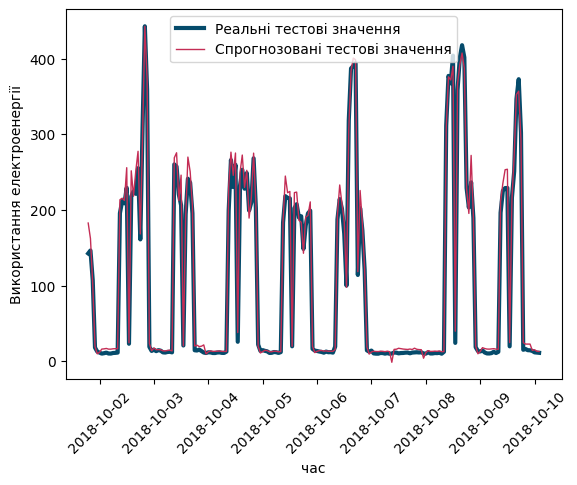

In [ ]:
real_test_values = y_test
real_test_values = list(real_test_values)
predicted_test_values = test_predictions
list1 = y_test1.index
predicted_test_values = pd.Series(predicted_test_values, list1)
real_test_values = pd.Series(real_test_values, list1)
# построение графика
plt.plot(real_test_values[0:200], linewidth=3, color='#054b6b', label='Реальні тестові значення')
plt.plot(predicted_test_values[0:200], linewidth=1, color='#c42d55', label='Спрогнозовані тестові значення')
plt.legend()
plt.ylabel('Використання електроенергії')
plt.xlabel('час')
plt.xticks(rotation=45)
plt.show()

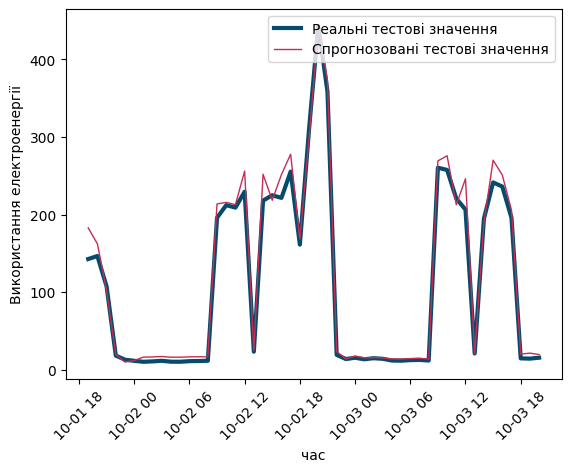

In [ ]:
plt.plot(real_test_values[0:50], linewidth=3, color='#054b6b', label='Реальні тестові значення')
plt.plot(predicted_test_values[0:50], linewidth=1, color='#c42d55', label='Спрогнозовані тестові значення')
plt.legend()
plt.ylabel('Використання електроенергії')
plt.xlabel('час')
plt.xticks(rotation=45)
plt.show()

## Linear Regression for data per 15 min


In [ ]:
X = df.drop('Usage_kWh', axis = 1)
y = df['Usage_kWh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle=False)

In [ ]:
LinReg = LinearRegression()
LinReg.fit(X_train, y_train)
LinReg.score(X_test, y_test)

0.9872770295515525

In [ ]:
train_predictions = LinReg.predict(X_train)
test_predictions = LinReg.predict(X_test)
print("Train MSE: {}".format(metrics.mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(metrics.mean_squared_error(y_test, test_predictions)))
print("Train MAE: {}".format(metrics.mean_absolute_error(y_train, train_predictions)))
print("Test MAE: {}".format(metrics.mean_absolute_error(y_test, test_predictions)))
print("Train RMSE: {}".format(math.sqrt(metrics.mean_squared_error(y_train, train_predictions))))
print("Test RMSE: {}".format(math.sqrt(metrics.mean_squared_error(y_test, test_predictions))))
print("Train MAPE: {}".format(metrics.mean_absolute_percentage_error(y_train, train_predictions)))
print("Test MAPE: {}".format(metrics.mean_absolute_percentage_error(y_test, test_predictions)))

Train MSE: 24.89151129336295
Test MSE: 13.045630885414244
Train MAE: 2.6759073089506926
Test MAE: 2.411528920016739
Train RMSE: 4.989139333929545
Test RMSE: 3.611873597651812
Train MAPE: 0.17575816699647928
Test MAPE: 6586835947964.459


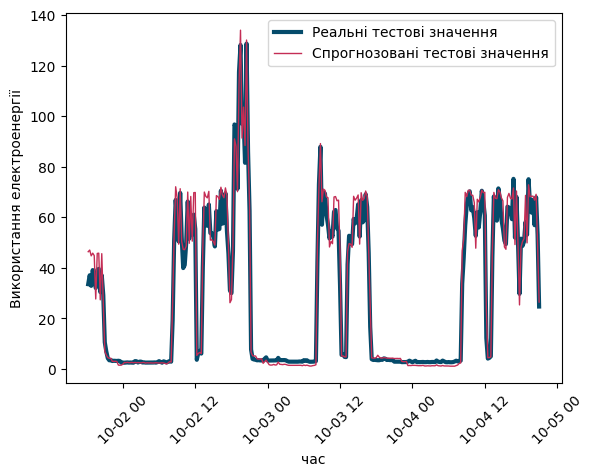

In [ ]:
real_test_values = y_test
predicted_test_values = test_predictions
list1 = X_test.index
predicted_test_values = pd.Series(predicted_test_values, list1)
real_test_values = pd.Series(real_test_values, list1)
# построение графика
plt.plot(real_test_values[0:300], linewidth=3, color='#054b6b', label='Реальні тестові значення')
plt.plot(predicted_test_values[0:300], linewidth=1, color='#c42d55', label='Спрогнозовані тестові значення')
plt.legend()
plt.ylabel('Використання електроенергії')
plt.xlabel('час')
plt.xticks(rotation=45)
plt.show()

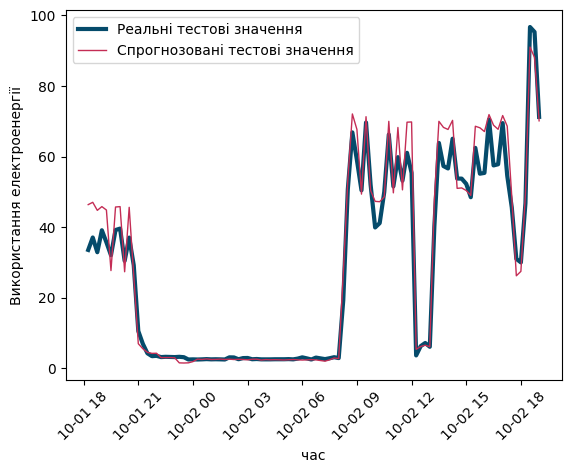

In [ ]:
plt.plot(real_test_values[0:100], linewidth=3, color='#054b6b', label='Реальні тестові значення')
plt.plot(predicted_test_values[0:100], linewidth=1, color='#c42d55', label='Спрогнозовані тестові значення')
plt.legend()
plt.ylabel('Використання електроенергії')
plt.xlabel('час')
plt.xticks(rotation=45)
plt.show()

## Перевірка можливості додавання 4ьох прогнозів 15-ти хвилинних даних для визначення погодинного прогнозу

In [ ]:
ser_train = pd.Series(train_predictions, index = y_train.index)

In [ ]:
ser_test = pd.Series(test_predictions, index=y_test.index)

Передбачений юзейч по 15 хвилинним данним, об'єднаний по годинам

In [ ]:
hourser_train = []
index_train = []
counter = 0
sumEn = 0
for i, energy in enumerate(ser_train):
  counter = counter + 1
  sumEn = sumEn + energy
  if counter == 4:
    hourser_train.append(sumEn)
    index_train.append(ser_train.index[i])
    counter = 0
    sumEn = 0
len(hourser_train), len(index_train)

(6570, 6570)

In [ ]:
hourser_test = []
index_test = []
counter = 0
sumEn = 0
for i, energy in enumerate(ser_test):
  counter = counter + 1
  sumEn = sumEn + energy
  if counter == 4:
    hourser_test.append(sumEn)
    index_test.append(ser_test.index[i])
    counter = 0
    sumEn = 0
len(hourser_test), len(index_test)

(2190, 2190)

**Предсказанные данные почасовой тестовой выборки с помощью 15-минутных данных**



In [ ]:
ser_test_hour = pd.Series(hourser_test, index=index_test)
ser_test_hour

2018-10-01 19:00:00    184.031435
2018-10-01 20:00:00    164.097952
2018-10-01 21:00:00    106.239545
2018-10-01 22:00:00     18.643645
2018-10-01 23:00:00     12.181118
                          ...    
2018-12-31 20:00:00     11.021153
2018-12-31 21:00:00     10.537880
2018-12-31 22:00:00     10.394123
2018-12-31 23:00:00     13.649851
2019-01-01 00:00:00     18.086838
Length: 2190, dtype: float64

**Сравнение результатов с реальными почасовыми данными (график)**

In [ ]:
X = df_hourscolumn.drop('Usage', axis = 1)
y = df_hourscolumn['Usage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle=False)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.25, random_state = 42, shuffle=False)

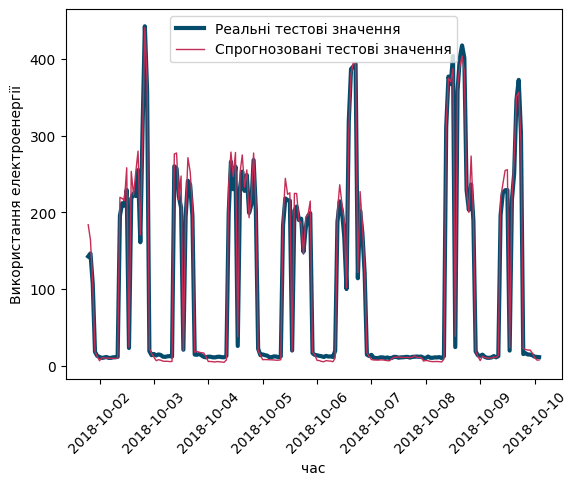

In [ ]:
real_test_values = y_test
real_test_values = list(real_test_values)
predicted_test_values = test_predictions
list1 = y_test1.index
predicted_test_values = ser_test_hour
real_test_values = pd.Series(real_test_values, list1)
# построение графика
plt.plot(real_test_values[0:200], linewidth=3, color='#054b6b', label='Реальні тестові значення')
plt.plot(predicted_test_values[0:200], linewidth=1, color='#c42d55', label='Спрогнозовані тестові значення')
plt.legend()
plt.ylabel('Використання електроенергії')
plt.xlabel('час')
plt.xticks(rotation=45)
plt.show()


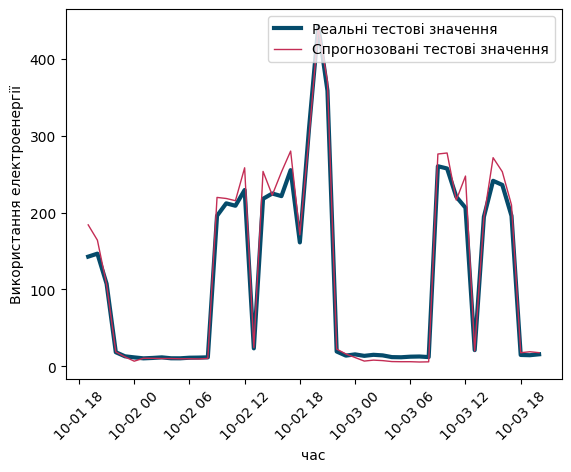

In [ ]:
# построение графика
plt.plot(real_test_values[0:50], linewidth=3, color='#054b6b', label='Реальні тестові значення')
plt.plot(predicted_test_values[0:50], linewidth=1, color='#c42d55', label='Спрогнозовані тестові значення')
plt.legend()
plt.ylabel('Використання електроенергії')
plt.xlabel('час')
plt.xticks(rotation=45)
plt.show()

In [ ]:
print("Test MAE: {}".format(metrics.mean_absolute_error(y_test, ser_test_hour)))
print("Test RMSE: {}".format(math.sqrt(metrics.mean_squared_error(y_test, ser_test_hour))))
print("Test MAPE: {}".format(metrics.mean_absolute_percentage_error(y_test, ser_test_hour)))

Test MAE: 6.880250141864852
Test RMSE: 9.65197597100116
Test MAPE: 0.18390646965813284


#Cubist and MLP for 1h and 15min

## cubist 15 min


Разделение на тестовую и учебную выборки

In [ ]:
X = df.drop('Usage_kWh', axis = 1)
y = np.asarray(df['Usage_kWh'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle=False)

Пример поиска гиперпараметров

In [ ]:
#model = Cubist()
#params = {
#    'n_committees': [30, 36, 39],
#    'neighbors': [1, 3, 6, 9],
#    'n_rules': [300, 600],
#    'extrapolation': [0.05, 0.1, 0.2]
#
#}
#tscv = TimeSeriesSplit(n_splits=3)
#grid_search = GridSearchCV(model, param_grid=params, cv=tscv, verbose=2)
#grid_search.fit(X_train_scaled, y_train)
#print("Наилучшие параметры: {}".format(grid_search.best_params_))
#Наилучшие параметры: {'extrapolation': 0.2, 'n_committees': 36, 'n_rules': 600, 'neighbors': 3}
#Train MAE: 0.019978459901824192
#Test MAE: 0.056197427960835614
#Train RMSE: 0.09344264567661258
#Test RMSE: 0.2278581737680962
#Train MAPE: 0.0009667957781476579
#Test MAPE: 1229952260535.5334

Обучение модели

In [ ]:
model = Cubist(n_committees=36, neighbors=3, n_rules=600, extrapolation=0.2) # <- model parameters here
model.fit(X_train, y_train)
# model.predict(X_test)
# model.score(X, y)

/usr/local/lib/python3.10/dist-packages/cubist/_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}


Cubist(extrapolation=0.2, n_committees=36, n_rules=600, neighbors=3)

In [ ]:
def mape_exclude_zero(y_true, y_pred):
    mask = y_true != 0
    y_true_no_zero = y_true[mask]
    y_pred_no_zero = y_pred[mask]
    return metrics.mean_absolute_percentage_error(y_true_no_zero, y_pred_no_zero)


Оценка метрык качества

In [ ]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
print("Train MAE: {}".format(metrics.mean_absolute_error(y_train, train_predictions)))
print("Test MAE: {}".format(metrics.mean_absolute_error(y_test, test_predictions)))
print("Train RMSE: {}".format(math.sqrt(metrics.mean_squared_error(y_train, train_predictions))))
print("Test RMSE: {}".format(math.sqrt(metrics.mean_squared_error(y_test, test_predictions))))
print("Train MAPE: {}".format(metrics.mean_absolute_percentage_error(y_train, train_predictions)))
print("Test MAPE: {}".format(mape_exclude_zero(y_test, test_predictions)))

Train MAE: 0.019978459901824192
Test MAE: 0.056197427960835614
Train RMSE: 0.09344264567661258
Test RMSE: 0.2278581737680962
Train MAPE: 0.0009667957781476579
Test MAPE: 0.008241849266344053


In [ ]:
RMSE_value = metrics.mean_squared_error(y_test, test_predictions, squared=False)
mean_value = np.mean(y_test)
CV = (RMSE_value / mean_value) * 100
print("Test CV: {}".format(CV))

Test CV: 0.87331298217356


Графики

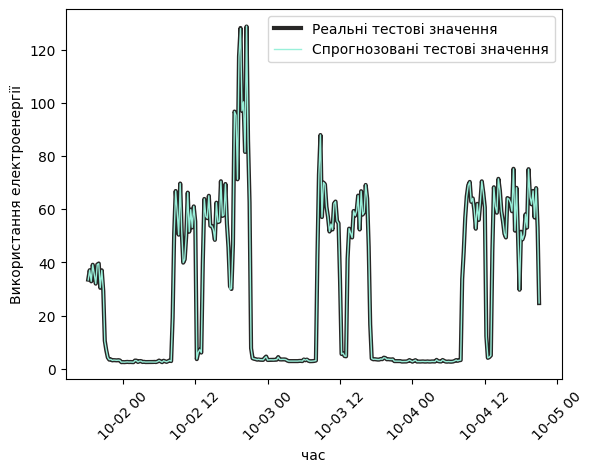

In [ ]:
real_test_values = y_test
predicted_test_values = test_predictions
list1 = X_test.index
predicted_test_values = pd.Series(predicted_test_values, list1)
real_test_values = pd.Series(real_test_values, list1)
# построение графика
plt.plot(real_test_values[0:300], linewidth=3, color='#282726', label='Реальні тестові значення')
plt.plot(predicted_test_values[0:300], linewidth=1, color='#99f0da', label='Спрогнозовані тестові значення')
plt.legend()
plt.ylabel('Використання електроенергії')
plt.xlabel('час')
plt.xticks(rotation=45)
plt.show()


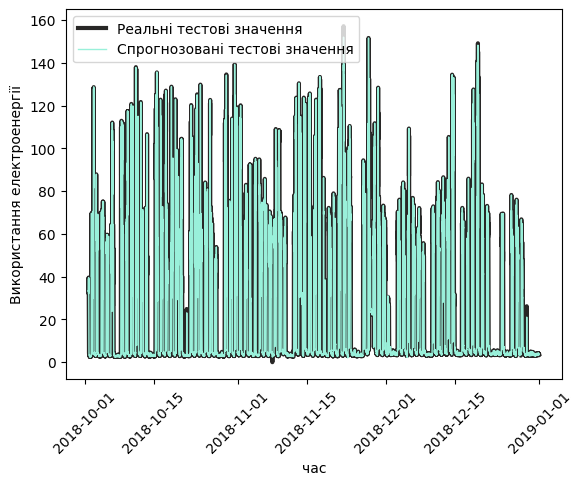

In [ ]:
# построение графика
plt.plot(real_test_values, linewidth=3, color='#282726', label='Реальні тестові значення')
plt.plot(predicted_test_values, linewidth=1, color='#99f0da', label='Спрогнозовані тестові значення')
plt.legend()
plt.ylabel('Використання електроенергії')
plt.xlabel('час')
plt.xticks(rotation=45)
plt.show()

## hourly cubist

Разделение на тестовую и учебную выборки

In [ ]:
X = df_hourscolumn.drop('Usage', axis = 1)
y = df_hourscolumn['Usage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle=False)

In [ ]:
X1 = df_hourly.drop('Usage', axis = 1)
y1 = df_hourly['Usage']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.25, random_state = 42, shuffle=False)

Пример поиска гиперпараметров

In [ ]:
#model = Cubist()
#params = {
#    'n_committees': [42, 50, 55, 56, 54, 60, 90, 100, 120],
#    'neighbors': [3, 6, 9],
#    'n_rules': [500, 300, 400, 600],
#    'extrapolation':[0.1, 0.2, 0.3]

#}
#tscv = TimeSeriesSplit(n_splits=3)
#grid_search = GridSearchCV(model, param_grid=params, cv=tscv, verbose=2)
#grid_search.fit(X_train_scaled, y_train)
#print("Наилучшие параметры: {}".format(grid_search.best_params_))

Обучение модели

In [ ]:
model = Cubist(n_committees=90, neighbors=9, n_rules=500, extrapolation=0.3) # <- model parameters here
model.fit(X_train, y_train)
# model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/cubist/_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}


Cubist(extrapolation=0.3, n_committees=90, neighbors=9)

Оценка метрык качества

In [ ]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
print("Train MAE: {}".format(metrics.mean_absolute_error(y_train, train_predictions)))
print("Test MAE: {}".format(metrics.mean_absolute_error(y_test, test_predictions)))
print("Train RMSE: {}".format(math.sqrt(metrics.mean_squared_error(y_train, train_predictions))))
print("Test RMSE: {}".format(math.sqrt(metrics.mean_squared_error(y_test, test_predictions))))
print("Train MAPE: {}".format(metrics.mean_absolute_percentage_error(y_train, train_predictions)))
print("Test MAPE: {}".format(metrics.mean_absolute_percentage_error(y_test, test_predictions)))

Train MAE: 1.7332114120843385
Test MAE: 2.056091496715807
Train RMSE: 3.2265584637051816
Test RMSE: 3.965530751719996
Train MAPE: 0.07404216595843191
Test MAPE: 0.08665238600409353


In [ ]:
RMSE_value = metrics.mean_squared_error(y_test, test_predictions, squared=False)
mean_value = np.mean(y_test)
CV = (RMSE_value / mean_value) * 100
print("Test CV: {}".format(CV))

Test CV: 3.7996679583055184


Графики

In [ ]:
real_test_values = y_test
real_test_values = list(real_test_values)
predicted_test_values = test_predictions
list1 = y_test1.index
predicted_test_values = pd.Series(predicted_test_values, list1)
real_test_values = pd.Series(real_test_values, list1)
# построение графика
plt.plot(real_test_values[0:200], linewidth=3, color='#282726', label='Реальні тестові значення')
plt.plot(predicted_test_values[0:200], linewidth=1, color='#99f0da', label='Спрогнозовані тестові значення')
plt.legend()
plt.ylabel('Використання електроенергії')
plt.xlabel('час')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# построение графика
plt.plot(real_test_values, linewidth=3, color='#282726', label='Реальні тестові значення')
plt.plot(predicted_test_values, linewidth=1, color='#99f0da', label='Спрогнозовані тестові значення')
plt.legend()
plt.ylabel('Використання електроенергії')
plt.xlabel('час')
plt.xticks(rotation=45)
plt.show()


##MAIN for hour neural network

Разделение на тестовую и учебную выборки

In [ ]:
X = df_hourscolumn.drop('Usage', axis = 1)
y = df_hourscolumn['Usage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle=False)

In [ ]:
scaler = StandardScaler()
# масштабування данних
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Пример поиска гиперпараметров

In [ ]:
#model = MLPRegressor(early_stopping=True, n_iter_no_change=1000, tol = 0, max_iter=100000)
#params = {
#    'hidden_layer_sizes': [(100, 100), (10, 10, 10, 10), (10, 10, 10), (20,20,20), (30, 30, 30)],
#    'learning_rate': ['adaptive'],
#    'learning_rate_init': [0.1, 0.2, 0.05],
#    'alpha': [0.0001, 0.00001, 0.00015]
#}
#tscv = TimeSeriesSplit(n_splits=10)
#grid_search = GridSearchCV(model, param_grid=params, cv=tscv)
#grid_search.fit(X_train_scaled, y_train)
#print("Наилучшие параметры: {}".format(grid_search.best_params_))

Обучение модели

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=((10, 10, 10)), early_stopping=True, n_iter_no_change=1000, tol = 0, max_iter=100000, learning_rate = "constant", learning_rate_init=0.1, alpha = 5e-05)

In [ ]:
mlp.fit(X_train_scaled, y_train)
mlp.score(X_train_scaled, y_train), mlp.score(X_test_scaled, y_test)

(0.998309158366187, 0.9983238734610805)

Оценка метрык качества

In [ ]:
#mlp = MLPRegressor(hidden_layer_sizes=((10, 10, 10)), early_stopping=True, n_iter_no_change=1000, tol = 0, max_iter=100000, learning_rate = "constant", learning_rate_init=0.1, alpha = 5e-05)
#MAAAIN
test_predictions = mlp.predict(X_test_scaled)
print("Test MAE: {}".format(metrics.mean_absolute_error(y_test, test_predictions)))
print("Test RMSE: {}".format(math.sqrt(metrics.mean_squared_error(y_test, test_predictions))))
print("Test MAPE: {}".format(metrics.mean_absolute_percentage_error(y_test, test_predictions)))

Test MAE: 3.134866089344591
Test RMSE: 5.064923748846305
Test MAPE: 0.09377367576465535


In [ ]:
RMSE_value = metrics.mean_squared_error(y_test, test_predictions, squared=False)
mean_value = np.mean(y_test)
CV = (RMSE_value / mean_value) * 100
print("Test CV: {}".format(CV))

Test CV: 4.8530776041529124


Графики

In [ ]:
real_test_values = y_test
real_test_values = list(real_test_values)
predicted_test_values = test_predictions
list1 = y_test1.index
predicted_test_values = pd.Series(predicted_test_values, list1)
real_test_values = pd.Series(real_test_values, list1)
# построение графика
plt.plot(real_test_values[0:200], linewidth=3, color='#282726', label='Реальні тестові значення')
plt.plot(predicted_test_values[0:200], linewidth=1, color='#99f0da', label='Спрогнозовані тестові значення')
plt.legend()
plt.ylabel('Використання електроенергії')
plt.xlabel('час')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# построение графика
plt.plot(real_test_values, linewidth=3, color='#282726', label='Реальні тестові значення')
plt.plot(predicted_test_values, linewidth=1, color='#99f0da', label='Спрогнозовані тестові значення')
plt.legend()
plt.ylabel('Використання електроенергії')
plt.xlabel('час')
plt.xticks(rotation=45)
plt.show()



##Main 15 neural network

Разделение на тестовую и учебную выборки

In [ ]:
X = df.drop('Usage_kWh', axis = 1)
y = np.asarray(df['Usage_kWh'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle=False)

In [ ]:
scaler = StandardScaler()
# масштабування данних
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Пример поиска гиперпараметров

In [ ]:
#model = MLPRegressor(early_stopping=True, n_iter_no_change=1000, tol = 0, max_iter=100000)
#params = {
#    # 'hidden_layer_sizes': [(10, 10, 10), (20, 20, 20), (30, 30, 30)],
#    'hidden_layer_sizes': [[100], [20, 10]],
#   'learning_rate_init': [0.001, 0.0001, 0.00001],
#    'alpha': [0.0001, 0.00001]
#}
#tscv = TimeSeriesSplit(n_splits=2)
#grid_search = GridSearchCV(model, param_grid=params, cv=tscv, verbose=2)
#grid_search.fit(X_train_scaled, y_train)
#print("Наилучшие параметры: {}".format(grid_search.best_params_))

Обучение модели

In [ ]:
#краща модель
mlp = MLPRegressor(hidden_layer_sizes=((100,)),
                   learning_rate_init=0.0001, alpha = 0.0001,
                   early_stopping=True, n_iter_no_change=1000, tol = 0, max_iter=100000)

In [ ]:
mlp.fit(X_train_scaled, y_train)
mlp.score(X_train_scaled, y_train), mlp.score(X_test_scaled, y_test)

(0.9998738012416123, 0.9993303734452901)

In [ ]:
def mape_exclude_zero(y_true, y_pred):
    mask = y_true != 0
    y_true_no_zero = y_true[mask]
    y_pred_no_zero = y_pred[mask]
    return metrics.mean_absolute_percentage_error(y_true_no_zero, y_pred_no_zero)

Оценка метрык качества

In [ ]:
test_predictions = mlp.predict(X_test_scaled)
print("Test MAE: {}".format(metrics.mean_absolute_error(y_test, test_predictions)))
print("Test RMSE: {}".format(math.sqrt(metrics.mean_squared_error(y_test, test_predictions))))
print("Test MAPE: {}".format(mape_exclude_zero(y_test, test_predictions)))

Test MAE: 0.24629592170710393
Test RMSE: 0.8286184857934642
Test MAPE: 0.033197891423349925


In [ ]:
RMSE_value = metrics.mean_squared_error(y_test, test_predictions, squared=False)
mean_value = np.mean(y_test)
CV = (RMSE_value / mean_value) * 100
print("Test CV: {}".format(CV))

Test CV: 1.915487804312492


Графики

In [ ]:
real_test_values = y_test
predicted_test_values = test_predictions
list1 = X_test.index
predicted_test_values = pd.Series(predicted_test_values, list1)
real_test_values = pd.Series(real_test_values, list1)
# построение графика
plt.plot(real_test_values[0:300], linewidth=3, color='#282726', label='Реальні тестові значення')
plt.plot(predicted_test_values[0:300], linewidth=1, color='#99f0da', label='Спрогнозовані тестові значення')
plt.legend()
plt.ylabel('Використання електроенергії')
plt.xlabel('час')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# построение графика
plt.plot(real_test_values, linewidth=3, color='#282726', label='Реальні тестові значення')
plt.plot(predicted_test_values, linewidth=1, color='#99f0da', label='Спрогнозовані тестові значення')
plt.legend()
plt.ylabel('Використання електроенергії')
plt.xlabel('час')
plt.xticks(rotation=45)
plt.show()